# Run Log Charts

Notebook to develop chart based on daily run log

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import boto3
import os

import plotly.express as px

## Read in data

In [631]:
# Read in from local
# raw_data_df = pd.read_csv('Workout log - DailyRunLog.csv')

# Read in data from s3
bucket = "jeremyruns.com"
file_name = "daily_run_log.csv"

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket= bucket, Key= file_name) 
raw_data_df = pd.read_csv(obj['Body'])

print(f'Records read in: {raw_data_df.shape[0]}')
#raw_data_df.dtypes

Records read in: 3533


### Process data, create rolling average variables

In [632]:
def preprocess_raw_df(df_) -> pd.DataFrame:
    """ Function to preprocess raw daily data """
    df_ = (df_
           .assign(Date=pd.to_datetime(df_["Date"]))  # Make Date a datetime object
           .assign(Miles=lambda x: df_['Miles'].fillna(0))  # Fill missing miles with 0
           .assign(MA_10day=df_['Miles'].rolling(window=10).mean())  # Create rolling averages
           .assign(MA_30day=df_['Miles'].rolling(window=30).mean())
           .sort_values('Date')
          )
    return df_

In [633]:
_df = raw_data_df.copy()
_df = _df.pipe(preprocess_raw_df)
_df = _df[_df['Date'] < datetime.datetime.today()]
_df['MA_10day'] = _df['Miles'].rolling(window=10).mean()
_df['MA_30day'] = _df['Miles'].rolling(window=30).mean()

In [634]:
# Notebook checks

days_of_data = _df.shape[0]
print(f'Days of data: {days_of_data}')
print(f'Years of data: {round(days_of_data/365.0,2)}')

total_miles_run = _df["Miles"].sum()
print(f'Total miles run: {total_miles_run}')

_df.tail(10)

Days of data: 3526
Years of data: 9.66
Total miles run: 5361.7


Unnamed: 0       Date  Miles                          Notes  MA_10day  \
3516        3516 2023-03-06    4.0                treadmill 39min      2.96   
3517        3517 2023-03-07    3.0     treadmill 30min, legs lift      3.26   
3518        3518 2023-03-08    0.0                     bike 30min      2.96   
3519        3519 2023-03-09    4.5                treadmill 45min      3.01   
3520        3520 2023-03-10    3.1     row 10min, treadmill 30min      3.01   
3521        3521 2023-03-11    0.0                      lift push      2.61   
3522        3522 2023-03-12    5.5  lift pull AM, treadmill 55min      2.86   
3523        3523 2023-03-13    3.1                treadmill 30min      2.87   
3524        3524 2023-03-14    4.0                treadmill 38min      2.72   
3525        3525 2023-03-15    0.0                            NaN      2.72   

      MA_30day  
3516  2.770000  
3517  2.766667  
3518  2.766667  
3519  2.916667  
3520  3.020000  
3521  3.020000  
3522  3.036667  
3523  3.036667  
3524  3.066667  
3525  2.963333

### Calculate stats

In [635]:
def calc_runstats(df: pd.DataFrame, num_days_back):
    """
    
    Function to calculate stats from daily running dataframe
    
    :input: df: pd.DataFrame
    :return: dict
    """
    runstats_output = {}
    runstats_output['num_days_back'] = num_days_back
    num_days_run = sum(df.tail(num_days_back)['Miles']>0)
    runstats_output['num_days_run'] = num_days_run
    runstats_output['pct_days_run'] = round(100.0*num_days_run/num_days_back,1)
    tot_miles_run = round(df.tail(num_days_back)['Miles'].sum(),1)
    runstats_output['tot_miles_run'] = tot_miles_run
    runstats_output['miles_per_day'] = round(tot_miles_run/num_days_back,2)
    runstats_output['miles_per_run'] = round(tot_miles_run/num_days_run,2)
    return runstats_output

In [636]:
last_30_stats_dict = calc_runstats(df=_df, num_days_back=30)
last_30_stats_dict

{'num_days_back': 30,
 'num_days_run': 23,
 'pct_days_run': 76.7,
 'tot_miles_run': 88.9,
 'miles_per_day': 2.96,
 'miles_per_run': 3.87}

In [637]:
def create_metrics_text_from_dict(metrics_dict):
    """
    Function to create text string from metrics dict
    """
    
    metrics_text_string = f"""Last {metrics_dict['num_days_back']} days: \
{metrics_dict['num_days_run']} runs, \
{metrics_dict['pct_days_run']}% of days, \
{metrics_dict['tot_miles_run']} miles, \
{metrics_dict['miles_per_day']} miles/day, \
{metrics_dict['miles_per_run']} miles/run\
"""
    
    return metrics_text_string

In [638]:
last_90_text = create_metrics_text_from_dict(calc_runstats(df=_df, num_days_back=90))
print(last_90_text)

Last 90 days: 61 runs, 67.8% of days, 239.2 miles, 2.66 miles/day, 3.92 miles/run


In [639]:
def create_last_run_text(df):
    """ Function to create text about the most recent run from df """
    last_run_date = pd.Timestamp(df[df['Miles']>0].tail(1)['Date'].values[0])
    last_run_distance = df[df['Miles']>0].tail(1)['Miles'].values[0]
    last_run_notes = df[df['Miles']>0].tail(1)['Notes'].values[0]

    if pd.isnull(df[df['Miles']>0].tail(1)['Notes'].values[0]):
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles"
    else:
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles ({last_run_notes})"

    return last_run_text

In [640]:
last_run_text = create_last_run_text(_df)
print(f'Last run: {last_run_text}')
site_last_updated = datetime.datetime.now().strftime('(%m/%d)')
print(f'Site last updated: {site_last_updated}')

Last run: Last Run: (03/14) - 4.0 miles (treadmill 38min)
Site last updated: (03/15)


## Plot data

In [12]:
import calmap

In [13]:
import numpy as np

In [641]:
_df.tail()

Unnamed: 0       Date  Miles                          Notes  MA_10day  \
3521        3521 2023-03-11    0.0                      lift push      2.61   
3522        3522 2023-03-12    5.5  lift pull AM, treadmill 55min      2.86   
3523        3523 2023-03-13    3.1                treadmill 30min      2.87   
3524        3524 2023-03-14    4.0                treadmill 38min      2.72   
3525        3525 2023-03-15    0.0                            NaN      2.72   

      MA_30day  
3521  3.020000  
3522  3.036667  
3523  3.036667  
3524  3.066667  
3525  2.963333

In [642]:
calmap_data = pd.Series(_df['Miles'].values[-730:], index=_df['Date'][-730:])

In [643]:
calmap_data

Date
2021-03-16    5.8
2021-03-17    0.0
2021-03-18    0.0
2021-03-19    4.7
2021-03-20    0.0
             ... 
2023-03-11    0.0
2023-03-12    5.5
2023-03-13    3.1
2023-03-14    4.0
2023-03-15    0.0
Length: 730, dtype: float64

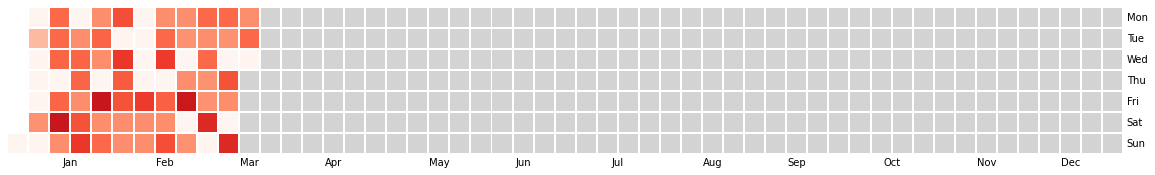

In [644]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)

# plt.figure(figsize=(15,10))
calmap.yearplot(calmap_data, year=2023, 
                fillcolor='lightgrey')
fig.savefig('calmap_2023.png')

<AxesSubplot:>

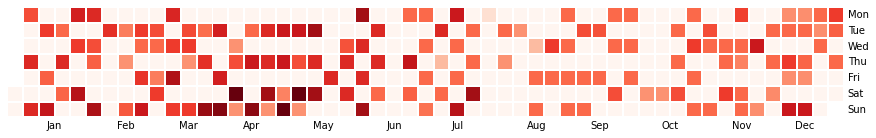

In [645]:
plt.figure(figsize=(15,10))
calmap.yearplot(calmap_data, year=2022, 
                fillcolor='lightgrey')

In [20]:
import plotly.graph_objects as go

In [21]:
days_back = 14
fig = px.scatter(y=_df.tail(days_back)['Miles'], 
                 x=_df.tail(days_back)['Date'], 
                 title=f'Last {days_back} days')
fig.update_traces(marker=dict(color='red'))
fig2 = px.line(y=_df.tail(days_back)['MA_30day'], 
                 x=_df.tail(days_back)['Date'])
fig3 = px.line(y=_df.tail(days_back)['MA_10day'], 
                 x=_df.tail(days_back)['Date'])

fig4 = go.Figure(data=fig.data + fig2.data + fig3.data, layout=fig.layout)

fig4['data'][1]['showlegend']=True
fig4['data'][1]['name'] = 'MA_30day'
fig4['data'][1]['line']['color'] = 'rgb(9,42,230)'

fig4['data'][2]['showlegend']=True
fig4['data'][2]['name'] = 'MA_10day'
fig4['data'][2]['line']['color'] = 'rgb(245,116,17)'

fig4.update_layout(
    title="Last 30 days",
    xaxis_title="Date",
    yaxis_title="Miles")

fig4.show()

In [14]:
# fig4.write_html('last_month_plotly.html', auto_open=True)

#### Plot weekly

In [646]:
_df['week_of_yr'] = _df['Date'].dt.strftime('%V')
_df['yr_wk'] = _df['Date'].dt.strftime('%Y') + "-" + _df['week_of_yr']

In [647]:
_df['yr_month'] = _df['Date'].dt.strftime('%Y') + "-" + _df['Date'].dt.strftime('%m')

In [648]:
_df['yr_month_lbl'] = _df['Date'].dt.strftime('%b-%y')

In [649]:
wkly_sum_df = _df.groupby(_df['yr_wk']).agg(wklyavg=('Miles', 'sum')).reset_index()

In [650]:
wkly_sum_df['6wks_rolling']=wkly_sum_df['wklyavg'].rolling(window=6).mean()
wkly_sum_df['3wks_rolling']=wkly_sum_df['wklyavg'].rolling(window=3).mean()

In [651]:
wkly_sum_df = wkly_sum_df[wkly_sum_df['yr_wk']<=datetime.datetime.now().strftime("%Y-%V")]

In [652]:
wkly_sum_df.tail(8)

yr_wk  wklyavg  6wks_rolling  3wks_rolling
500  2023-04     23.5     17.033333     24.300000
501  2023-05     24.7     19.300000     24.066667
502  2023-06     11.2     18.966667     19.800000
503  2023-07     24.0     22.133333     19.966667
504  2023-08     18.2     20.933333     17.800000
505  2023-09     22.6     20.700000     21.600000
506  2023-10     20.1     20.133333     20.300000
507  2023-11      7.1     17.200000     16.600000

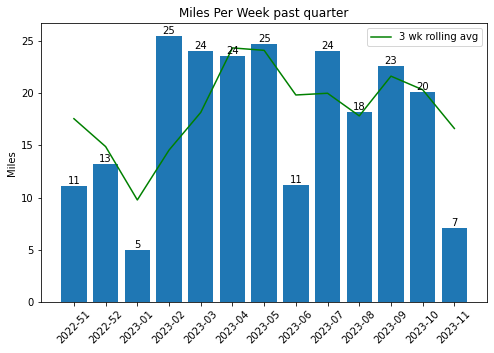

In [653]:
wkly_plot_df = wkly_sum_df.tail(13).reset_index()

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xticks(rotation=45)
ax.set_title('Miles Per Week past quarter')
ax.set_ylabel('Miles')
ax.bar(wkly_plot_df['yr_wk'],wkly_plot_df['wklyavg'])
ax.plot(wkly_plot_df['yr_wk'], wkly_plot_df['3wks_rolling'], color='green')
ax.legend(['3 wk rolling avg'])
plt.subplots_adjust(top=0.9)
#ax.set_ylabel('Miles')
#text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
#ax.set_title(f'{text_summary}')
#ax.title.set_size(20)
for i in range(len(wkly_plot_df['yr_wk'])):
    plt.text(i, 
             wkly_plot_df['wklyavg'][i]+0.2, 
             round(wkly_plot_df['wklyavg'][i]), ha='center')

In [654]:
def create_wkly_miles_chart(wkly_sum_df):
    """ Function to create weekly miles chart """
    wkly_plot_df = wkly_sum_df.tail(13).reset_index()

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    plt.xticks(rotation=45)
    title = ax.set_title('Miles Per Week past quarter', pad=20)
    title.set_weight('bold')
    title.set_size(16)
    ax.set_ylabel('Miles')
    ax.bar(wkly_plot_df['yr_wk'],wkly_plot_df['wklyavg'])
    ax.plot(wkly_plot_df['yr_wk'], wkly_plot_df['3wks_rolling'], color='green')
    for i in range(len(wkly_plot_df['yr_wk'])):
        plt.text(i, 
                 wkly_plot_df['wklyavg'][i]+0.2, 
                 round(wkly_plot_df['wklyavg'][i]), ha='center')
    fig.savefig('weekly_miles.png')

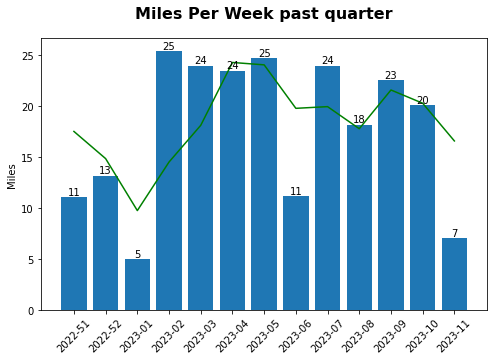

In [655]:
create_wkly_miles_chart(wkly_sum_df=wkly_sum_df)

### Monthly sums last year

In [656]:
monthly_sum_df = _df.groupby(_df['yr_month']).agg(miles_sum=('Miles', 'sum')).reset_index()
monthly_sum_df.head()

yr_month  miles_sum
0  2013-07       54.5
1  2013-08      115.5
2  2013-09       44.5
3  2013-10        5.0
4  2013-11        7.5

In [657]:
monthly_sum_df['6mo_rolling']=monthly_sum_df['miles_sum'].rolling(window=6).mean()
monthly_sum_df['3mo_rolling']=monthly_sum_df['miles_sum'].rolling(window=3).mean()

In [658]:
monthly_sum_df.tail(10)

yr_month  miles_sum  6mo_rolling  3mo_rolling
107  2022-06       55.4    69.483333    72.733333
108  2022-07       55.8    67.550000    62.766667
109  2022-08       37.0    65.050000    49.400000
110  2022-09       53.7    60.783333    48.833333
111  2022-10       35.6    52.433333    42.100000
112  2022-11       59.0    49.416667    49.433333
113  2022-12       73.0    52.350000    55.866667
114  2023-01       82.5    56.800000    71.500000
115  2023-02       80.6    64.066667    78.700000
116  2023-03       42.7    62.233333    68.600000

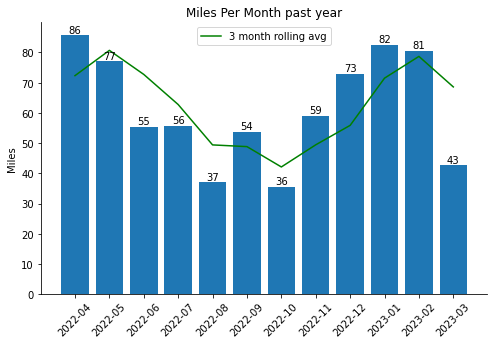

In [659]:
month_plot_df = monthly_sum_df.tail(12).reset_index()

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xticks(rotation=45)
ax.set_title('Miles Per Month past year')
ax.set_ylabel('Miles')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.bar(month_plot_df['yr_month'], month_plot_df['miles_sum'])
ax.plot(month_plot_df['yr_month'], month_plot_df['3mo_rolling'], color='green')
ax.legend(['3 month rolling avg'])
for i in range(len(month_plot_df['yr_month'])):
    plt.text(i, 
             month_plot_df['miles_sum'][i]+0.8, 
             round(month_plot_df['miles_sum'][i]), ha='center')

In [660]:
def create_monthly_miles_chart(monthly_sum_df):
    """ Function to create monthly miles chart """
    month_plot_df = monthly_sum_df.tail(12).reset_index()

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    plt.xticks(rotation=45)
    ax.set_title('Miles Per Month past year')
    ax.set_ylabel('Total Miles')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.bar(month_plot_df['yr_month'], month_plot_df['miles_sum'])
    ax.plot(month_plot_df['yr_month'], month_plot_df['3mo_rolling'], color='green')
    ax.legend(['3_month_rolling_avg'])
    for i in range(len(month_plot_df['yr_month'])):
        plt.text(i, 
                 month_plot_df['miles_sum'][i]+0.8, 
                 round(month_plot_df['miles_sum'][i]), ha='center')
    fig.savefig('monthly_miles.png')

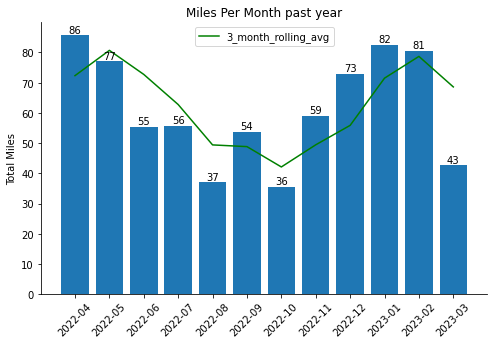

In [661]:
create_monthly_miles_chart(monthly_sum_df = monthly_sum_df)

### Cumulative miles over time for this month

In [744]:
current_yr_month = max(_df['yr_month'])
cur_month_df = _df[_df['yr_month']==current_yr_month][['Date', 'Miles']].copy()

In [745]:
cur_month_df.shape

(15, 2)

In [746]:
cur_month_df.dtypes

Date     datetime64[ns]
Miles           float64
dtype: object

In [747]:
cur_month_df['cumulative_miles'] = cur_month_df['Miles'].cumsum()

In [726]:
from datetime import datetime, date, timedelta

In [727]:
import calendar

In [750]:
# Get current date and extract year and month
current_date = datetime.now()
current_year = current_date.year
current_month = current_date.month

# Get last day of current month
last_day = calendar.monthrange(current_year, current_month)[1]

print(last_day)

31


In [751]:
# Get current date and extract year and month
current_date = datetime.now()
current_year = current_date.year
current_month = current_date.month

# Create end date for resampling
last_day = calendar.monthrange(current_year, current_month)[1]

In [752]:
date_range = pd.date_range(start=current_date, 
                           end=datetime.strptime(f'{current_year}-{current_month}-{last_day}', '%Y-%m-%d'), 
                           freq='D')

In [753]:
date_range

DatetimeIndex(['2023-03-15 15:43:19.299377', '2023-03-16 15:43:19.299377',
               '2023-03-17 15:43:19.299377', '2023-03-18 15:43:19.299377',
               '2023-03-19 15:43:19.299377', '2023-03-20 15:43:19.299377',
               '2023-03-21 15:43:19.299377', '2023-03-22 15:43:19.299377',
               '2023-03-23 15:43:19.299377', '2023-03-24 15:43:19.299377',
               '2023-03-25 15:43:19.299377', '2023-03-26 15:43:19.299377',
               '2023-03-27 15:43:19.299377', '2023-03-28 15:43:19.299377',
               '2023-03-29 15:43:19.299377', '2023-03-30 15:43:19.299377'],
              dtype='datetime64[ns]', freq='D')

In [758]:
new_df = pd.DataFrame({'Date': date_range, 'Miles': None})

In [759]:
cur_month_df = pd.concat([cur_month_df, new_df])

In [760]:
cur_month_df.tail()

Date  Miles  cumulative_miles
11 2023-03-26 15:43:19.299377    NaN               NaN
12 2023-03-27 15:43:19.299377    NaN               NaN
13 2023-03-28 15:43:19.299377    NaN               NaN
14 2023-03-29 15:43:19.299377    NaN               NaN
15 2023-03-30 15:43:19.299377    NaN               NaN

In [768]:
last_point = cur_month_df.iloc[-1]

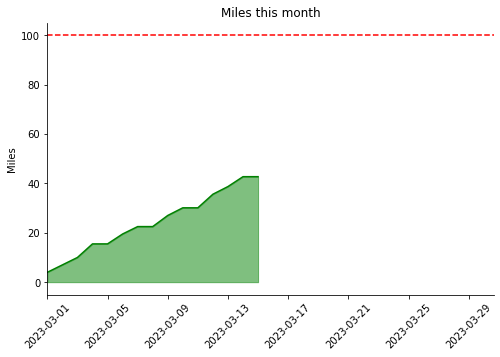

In [771]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xticks(rotation=45)
ax.set_title('Miles this month')
ax.set_ylabel('Miles')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(cur_month_df['Date'], 
        cur_month_df['cumulative_miles'], 
        color='green')

ax.set_xlim(min(cur_month_df['Date']), max(cur_month_df['Date']))
ax.fill_between(cur_month_df['Date'], 
                cur_month_df['cumulative_miles'], 
                alpha=0.5, 
                color='green')

plt.axhline(y=100, color='red', linestyle='--')

ax.annotate(f"{last_point['cumulative_miles']} miles",
            xy=(last_point['Date'], last_point['cumulative_miles']),
            xytext=(10, 15),
            textcoords='offset points',
            fontsize=12,
            fontweight='bold',
            ha='left',
            va='bottom',
            bbox=dict(boxstyle='round', fc='white', ec='gray', lw=2))

plt.show()

'nan miles'

### Last two weeks daily chart

In [560]:
_df['date_str_label'] = _df['Date'].dt.strftime('%b-%d')

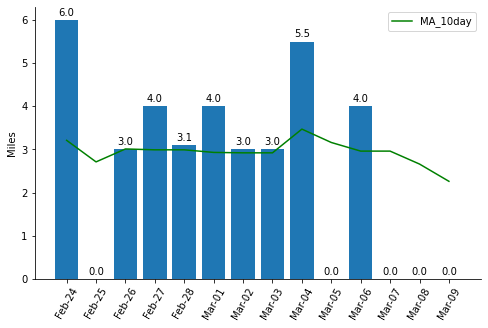

In [562]:
days_back = 14

daily_plot_df = _df.tail(days_back).reset_index()

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xticks(rotation=60)
ax.bar(daily_plot_df['date_str_label'],daily_plot_df['Miles'])
ax.set_xticks(daily_plot_df['date_str_label'])
ax.plot(daily_plot_df['date_str_label'],daily_plot_df['MA_10day'], color='green')
ax.legend(['MA_10day'])
ax.set_ylabel('Miles')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
text_summary = create_metrics_text_from_dict(calc_runstats(df=_df, num_days_back=days_back))
# ax.set_title(f'{text_summary}')
for i in range(days_back):
    plt.text(i, 
             daily_plot_df['Miles'][i] + 0.1, 
             round(daily_plot_df['Miles'][i],1), ha='center')

In [523]:
_df.head()

Unnamed: 0       Date  Miles Notes  MA_10day  MA_30day week_of_yr    yr_wk  \
0           0 2013-07-20    5.5   NaN       NaN       NaN         29  2013-29   
1           1 2013-07-21    6.5   NaN       NaN       NaN         29  2013-29   
2           2 2013-07-22    0.0   NaN       NaN       NaN         30  2013-30   
3           3 2013-07-23    5.5   NaN       NaN       NaN         30  2013-30   
4           4 2013-07-24    7.0   NaN       NaN       NaN         30  2013-30   

  yr_month date_str_label  
0  2013-07         Jul-20  
1  2013-07         Jul-21  
2  2013-07         Jul-22  
3  2013-07         Jul-23  
4  2013-07         Jul-24

In [565]:
def create_last2wks_charts(df):
    """ Function to create last 2 weeks daily chart """
    days_back = 14

    daily_plot_df = _df.tail(days_back).reset_index()

    fig, ax = plt.subplots(1,1, figsize=(9,6))
    plt.xticks(rotation=60)
    ax.bar(daily_plot_df['date_str_label'],daily_plot_df['Miles'])
    ax.set_xticks(daily_plot_df['date_str_label'])
    ax.plot(daily_plot_df['date_str_label'],daily_plot_df['MA_10day'], color='green')
    ax.legend(['MA_10day'])
    ax.set_ylabel('Miles')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    text_summary = create_metrics_text_from_dict(calc_runstats(df=_df, num_days_back=days_back))
    # ax.set_title(f'{text_summary}')
    for i in range(days_back):
        plt.text(i, 
                 daily_plot_df['Miles'][i] + 0.1, 
                 round(daily_plot_df['Miles'][i],1), ha='center')    
    fig.savefig('last_2wks_daily.png', dpi=200)

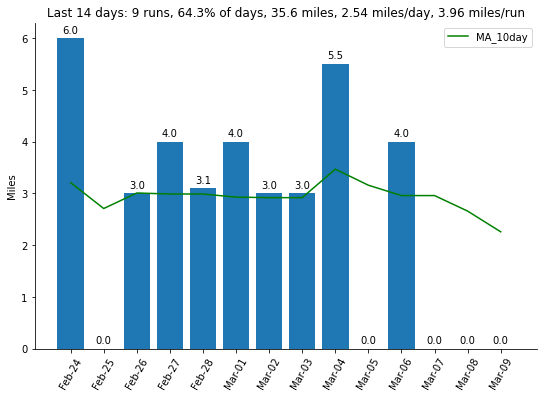

In [564]:
create_last2wks_charts(df=_df)

### Yearly total miles chart

In [566]:
yrly_sum_df = _df.groupby(_df['Date'].dt.strftime('%Y')).agg(miles_sum=('Miles', 'sum')).reset_index()
yrly_sum_df.tail()

Date  miles_sum
6   2019      477.6
7   2020      503.1
8   2021      658.3
9   2022      731.0
10  2023      182.6

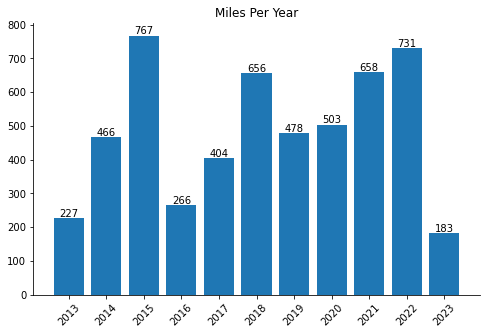

In [567]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xticks(rotation=45)
ax.set_title('Miles Per Year')
ax.bar(yrly_sum_df['Date'],yrly_sum_df['miles_sum'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in range(len(yrly_sum_df['Date'])):
    plt.text(i, 
             yrly_sum_df['miles_sum'][i]+5, 
             round(yrly_sum_df['miles_sum'][i]), ha='center')

In [568]:
def create_yearly_miles_chart(yrly_sum_df):
    """ Function to create yearly miles chart """
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    plt.xticks(rotation=45)
    ax.set_title('Miles Per Year')
    ax.bar(yrly_sum_df['Date'],yrly_sum_df['miles_sum'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for i in range(len(yrly_sum_df['Date'])):
        plt.text(i, 
                 yrly_sum_df['miles_sum'][i]+5, 
                 round(yrly_sum_df['miles_sum'][i]), ha='center')
    fig.savefig('yrly_miles.png')

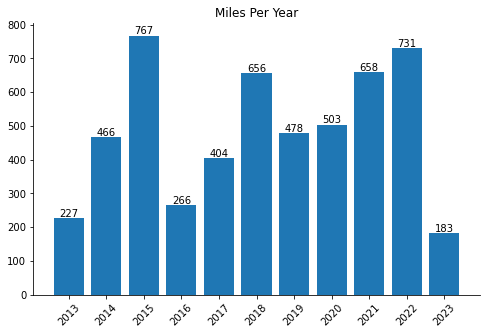

In [569]:
create_yearly_miles_chart(yrly_sum_df=yrly_sum_df)

### All charts

In [375]:
df = _df.copy()

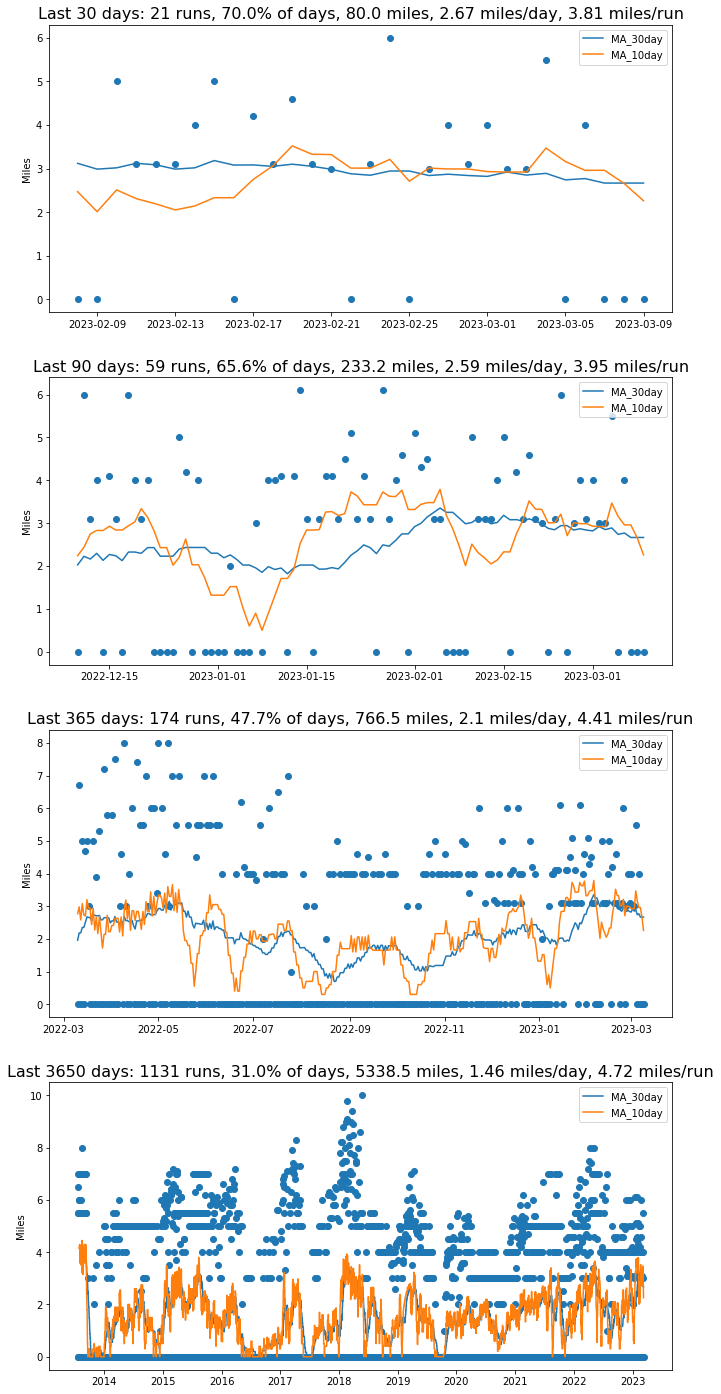

In [622]:
fig, ax = plt.subplots(4,1, figsize=(10,20))

days_back = 30
ax[0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[0].legend(['MA_30day', 'MA_10day'])
ax[0].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[0].set_title(f'{text_summary}')
ax[0].title.set_size(16)

days_back = 90
ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[1].legend(['MA_30day', 'MA_10day'])
ax[1].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[1].set_title(f'{text_summary}')
ax[1].title.set_size(16)

days_back = 365
ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[2].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[2].legend(['MA_30day', 'MA_10day'])
ax[2].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[2].set_title(f'{text_summary}')
ax[2].title.set_size(16)

days_back = 3650
ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[3].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[3].legend(['MA_30day', 'MA_10day'])
ax[3].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[3].set_title(f'{text_summary}')
ax[3].title.set_size(16)

fig.tight_layout(pad = 3.0)

plt.savefig('all_charts.png')

plt.show()

In [46]:
def create_all_charts(df):
    """ Function to create all charts in one single png """
    
    fig, ax = plt.subplots(4,1, figsize=(10,20))

    days_back = 30
    ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[0].legend(['MA_30day', 'MA_10day'])
    ax[0].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[0].set_title(f'{text_summary}')
    ax[0].title.set_size(16)

    days_back = 90
    ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[1].legend(['MA_30day', 'MA_10day'])
    ax[1].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[1].set_title(f'{text_summary}')

    days_back = 365
    ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[2].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[2].legend(['MA_30day', 'MA_10day'])
    ax[2].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[2].set_title(f'{text_summary}')

    days_back = 3650
    ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[3].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[3].legend(['MA_30day', 'MA_10day'])
    ax[3].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[3].set_title(f'{text_summary}')

    fig.tight_layout(pad = 3.0)

    fig.savefig('all_charts.png')

In [623]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\jeremyruns'

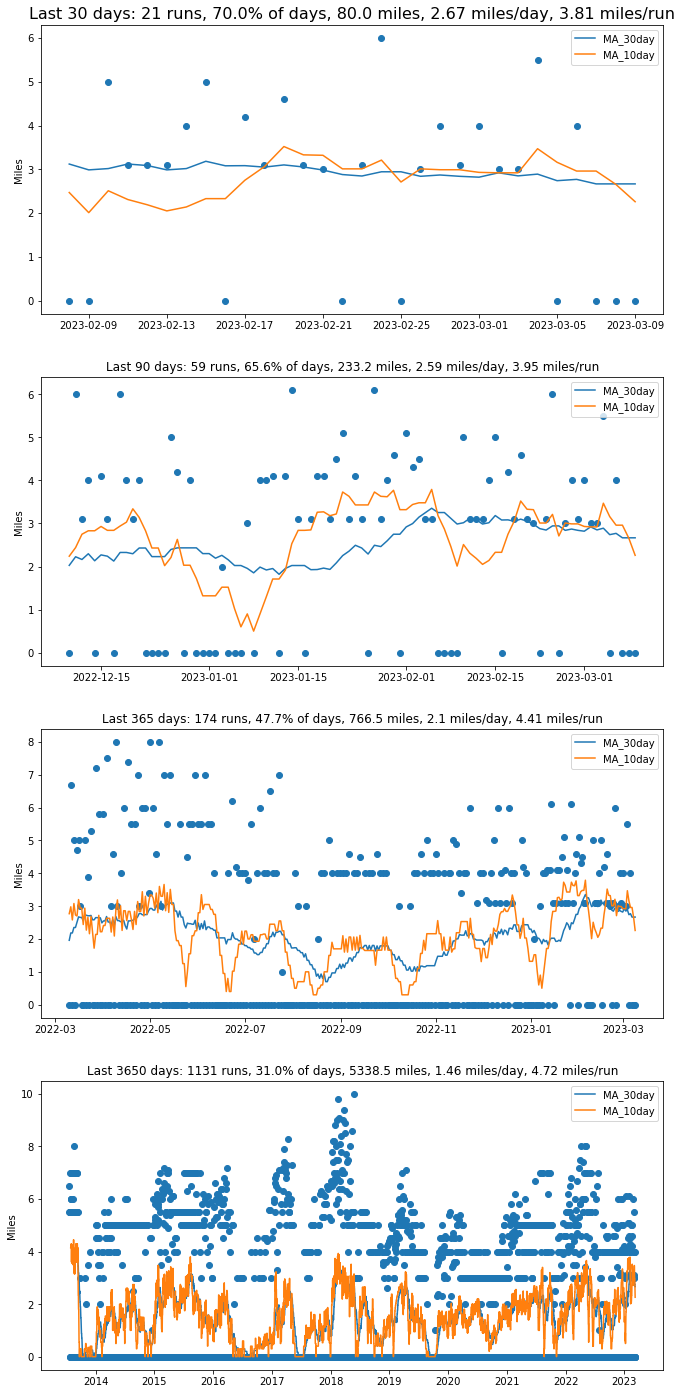

In [624]:
create_all_charts(df=df)

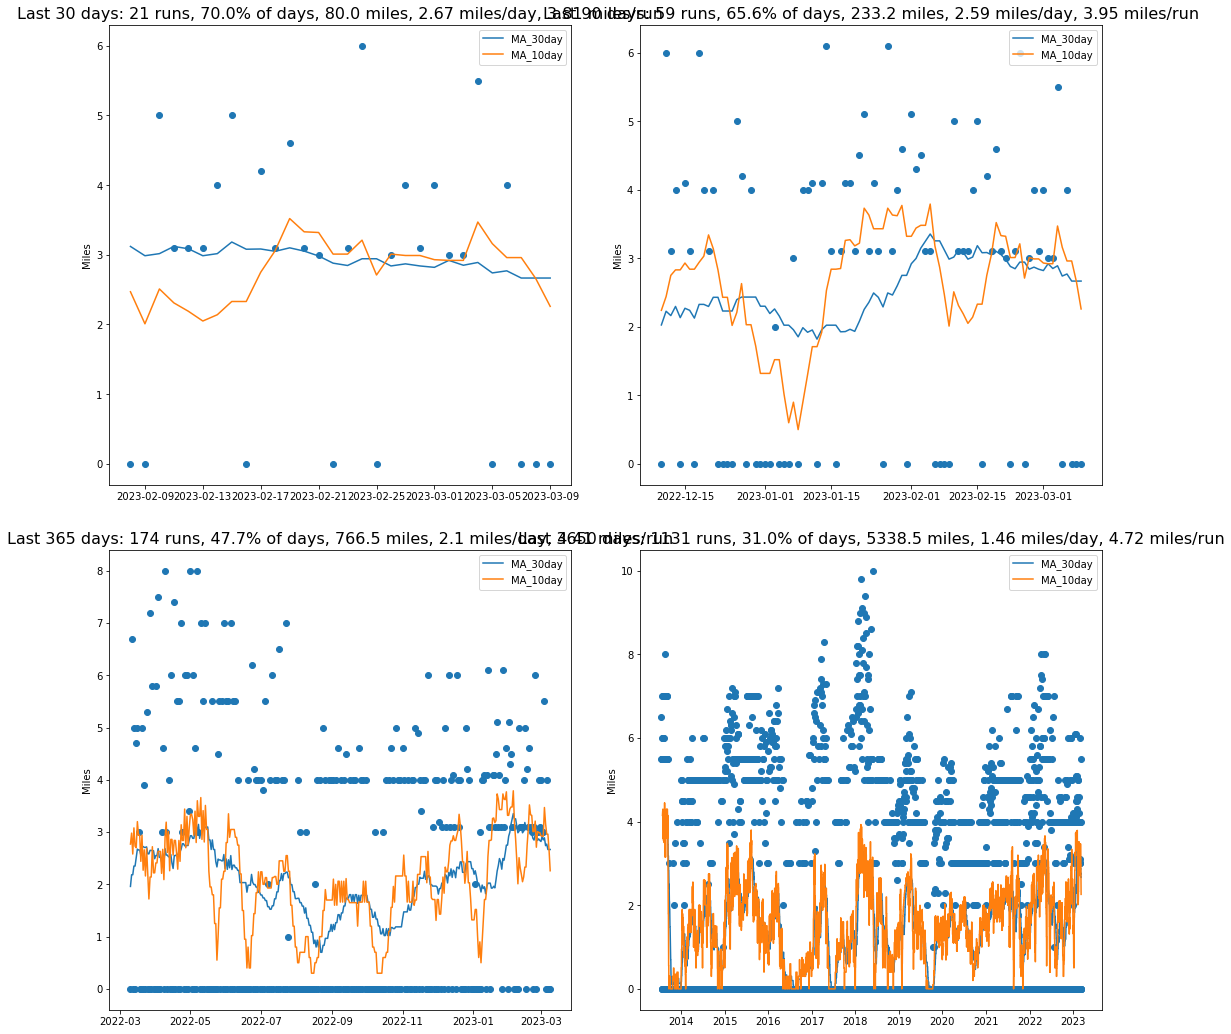

In [629]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

days_back = 30
ax[0][0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[0][0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[0][0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[0][0].legend(['MA_30day', 'MA_10day'])
ax[0][0].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[0][0].set_title(f'{text_summary}')
ax[0][0].title.set_size(16)

days_back = 90
ax[0][1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[0][1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[0][1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[0][1].legend(['MA_30day', 'MA_10day'])
ax[0][1].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[0][1].set_title(f'{text_summary}')
ax[0][1].title.set_size(16)

days_back = 365
ax[1][0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[1][0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[1][0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[1][0].legend(['MA_30day', 'MA_10day'])
ax[1][0].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[1][0].set_title(f'{text_summary}')
ax[1][0].title.set_size(16)

days_back = 3650
ax[1][1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[1][1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[1][1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[1][1].legend(['MA_30day', 'MA_10day'])
ax[1][1].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[1][1].set_title(f'{text_summary}')
ax[1][1].title.set_size(16)

fig.tight_layout(pad = 3.0)

plt.savefig('all_charts.png')

plt.show()

### Create html output for index

In [502]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\jeremyruns'

In [516]:
# check these variables exist
print(last_run_text)
print(site_last_updated)

Last Run: (03/06) - 4.0 miles (treadmill 39min)
(03/09)


#### Read in index_template.html

In [512]:
with open('index_template.html', 'r') as file:
    html_template_string = file.read()

In [520]:
html_template_string[0:10]

'\n<html xml'

#### Read in style sheet

In [514]:
with open('jeremyruns_style.txt', 'r') as file:
    style_text = file.read()

In [519]:
style_text[0:10]

'<style>\n\nh'

In [517]:
# Create index.html string
html_string = html_template_string.format(style_text=style_text,
                                   last_run_text=last_run_text, 
                                   site_last_updated=site_last_updated)

In [500]:
#### Write out index.html file local
# pwd

In [518]:
# Creating an HTML file
html_file = open("index.html","w")

# Adding input data to the HTML file
html_file.write(html_string)

# Saving the data into the HTML file
html_file.close()

In [774]:
# Recreate index file locally with html, css updates

# read in html
with open('index_template.html', 'r') as file:
    html_template_string = file.read()

# read in css
with open('jeremyruns_style.txt', 'r') as file:
    style_text = file.read()

# Create index.html string
html_string = html_template_string.format(style_text=style_text,
                                   last_run_text=last_run_text, 
                                   site_last_updated=site_last_updated)

# Creating index HTML file
html_file = open("index.html","w")

# Adding input data to the HTML file
html_file.write(html_string)

# Saving the data into the HTML file
html_file.close()

### Write files to s3 bucket

In [ ]:
s3_client = boto3.resource('s3')
bucket = s3_client.Bucket('jeremyruns.com')

In [ ]:
# index file
bucket.upload_file('index.html', 'index.html', ExtraArgs={'ContentType': 'text/html'})

In [ ]:
# all_charts
bucket.upload_file(f'all_charts.png', f'all_charts.png',
                               ExtraArgs={'ContentType': 'image/png'})

# Invalidate Cloudfront CDN after update

Note: This has been moved to a Lambda

In [ ]:
cloudfront_client = boto3.client('cloudfront')

In [ ]:
caller_reference = 'index_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
caller_reference

In [ ]:
caller_reference = 'index_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
cloudfront_client.create_invalidation(
    DistributionId='E1Z8D0K5RUED85',
    InvalidationBatch={
        'Paths': {
            'Quantity': 1,
            'Items': [
                '/index.html',
            ]
        },
        'CallerReference': caller_reference
    }
)

In [538]:
!pip freeze

aiohttp==3.8.3
aiosignal==1.3.1
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==4.2.0
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
async-timeout==4.0.2
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.fu